# Подготовка данных 

## Импортирую модули для работы

In [1]:
!pip install -U albumentations
import os
import numpy as np
from sklearn.model_selection import train_test_split
import random
import sklearn
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from keras import optimizers 
from sklearn.utils import class_weight
from tensorflow.keras.optimizers import SGD, Adam
!pip install opencv-python-headless==4.1.2.30
import cv2
import albumentations as A
from keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from random import seed
from random import randint
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from keras.models import model_from_json
from sklearn.metrics import cohen_kappa_score, roc_auc_score, roc_curve,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

     |████████████████████████████████| 102 kB 6.6 MB/s 
     |████████████████████████████████| 47.8 MB 71 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 21.8 MB 7.5 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.64
    Uninstalling opencv-python-headless-4.5.5.64:
      Successfully uninstalled opencv-python-headless-4.5.5.64


## Загружаю данные

In [2]:
import pandas as pd

from google.colab import drive 
drive.mount('/content/drive')

PATH = 'drive/MyDrive/input/'

Mounted at /content/drive


### разархивирую данные

In [3]:
# zip_data = "challenges-in-representation-learning-facial-expression-recognition-challenge.zip"

# with ZipFile(zip_data, 'r') as zip_: 
#     zip_.extractall(os.getcwd()+'/'+PATH)

### Получаю все данные из файла

In [4]:
dataset = pd.read_csv(PATH+'icml_face_data.csv')

## Показываю данные

### Смотрю описание данных
Имеется 35887 строк данных и имена столбцов, которые содержат данные (эмоции, пиксели, использование)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


### Проверяю часть записей
- emotion - целое число (0-6 эмоций)
- pixels - строка с разделёнными целыми числами
- Usage - категориальный атрибут

Пиксели - целые числа, и, так как изображения находятся в оттенках серого (из описания), поэтому они будут находиться в диапазоне 0-255

In [6]:
print(dataset.shape)
dataset.head()

(35887, 3)


,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


### Исправляю названия колонок таблицы

Убираю ненужные пробелы

In [7]:
print(dataset.keys())
dataset.columns = ['emotion', 'Usage', 'pixels']
print(dataset.keys())

Index(['emotion', ' Usage', ' pixels'], dtype='object')
Index(['emotion', 'Usage', 'pixels'], dtype='object')


### Получаю больше данных

Данные уже разделены для тестирования (Training, PublicTest, PrivateTest)

In [8]:
dataset["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

## Трансформирую входные пиксели для получения изображения

In [9]:
def show_image_and_label(x, y):
    x_reshaped = x.reshape(48, 48)
    plt.imshow(x_reshaped, cmap="gray", interpolation="nearest")
    plt.axis("off")
    plt.show()
    print("Emotion: ", y)

In [10]:
# x_pixels
img = dataset["pixels"][0]
val = img.split(" ")
x_pixels = np.array(val, 'float32')
x_pixels /= 255

Вот как выглядит первое изображение:

- 0=Angry
- 1=Disgust
- 2=Fear
- 3=Happy
- 4=Sad
- 5=Surprise
- 6=Neutral

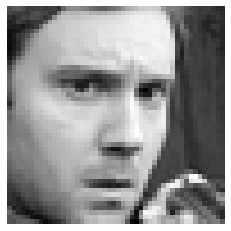

Emotion:  0


In [11]:
show_image_and_label(x_pixels, dataset["emotion"][0])

## Разделяю данные

In [12]:
test_dataset  = dataset.loc[dataset["Usage"] == 'PublicTest',['emotion','pixels']]
train_dataset = dataset.loc[dataset["Usage"] == 'Training', ['emotion', 'pixels']]
validation_dataset = dataset.loc[dataset["Usage"] == 'PrivateTest', ['emotion', 'pixels']]

In [13]:
print(dataset.shape)
dataset.head()

(35887, 3)


,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [14]:
validation_dataset.head()

,emotion,pixels
32298,0,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...
32299,5,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...
32300,6,232 240 241 239 237 235 246 117 24 24 22 13 12...
32301,4,200 197 149 139 156 89 111 58 62 95 113 117 11...
32302,2,40 28 33 56 45 33 31 78 152 194 200 186 196 20...


In [15]:
test_dataset.head()

,emotion,pixels
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


## Обрабатываю изображения
Преобразовываю dataset`ы пикселей в массивы

In [16]:
def pixels_to_array(pixels):
    array = np.array(pixels.split(),'uint8')
    return array

def image_reshape(data):
    image = np.reshape(data['pixels'].to_list(),(data.shape[0],48,48,1))
    image = np.repeat(image, 3, -1)
    return image

In [17]:
train_dataset['pixels'] = train_dataset['pixels'].apply(pixels_to_array)
test_dataset['pixels']  = test_dataset['pixels'].apply(pixels_to_array)
validation_dataset['pixels'] = validation_dataset['pixels'].apply(pixels_to_array)

print("Train:")
print(type(train_dataset['pixels']))
print(train_dataset.shape)

print("Validation:")
print(type(validation_dataset['pixels']))
print(validation_dataset.shape)

print("Test:")
print(type(test_dataset['pixels']))
print(test_dataset.shape)


X_train = image_reshape(train_dataset)
y_train = train_dataset['emotion']
print(X_train.shape)

X_test = image_reshape(test_dataset)
y_test = test_dataset['emotion']
print(X_test.shape)

X_val = image_reshape(validation_dataset)
y_val = validation_dataset['emotion']
print(X_val.shape)

Train:
<class 'pandas.core.series.Series'>
(28709, 2)
Validation:
<class 'pandas.core.series.Series'>
(3589, 2)
Test:
<class 'pandas.core.series.Series'>
(3589, 2)
(28709, 48, 48, 3)
(3589, 48, 48, 3)
(3589, 48, 48, 3)


# Аугментирую данные
Метод аугментации (увеличения данных искусственно) генерирует разные версии реального набора данных, чтобы увеличить его размер.

Я использовал метод альбументации, т. к.

__Альбументации__ — это инструмент __компьютерного зрения__, который повышает производительность глубоких __сверточных__ нейронных сетей.

Альбументации эффективно реализует широкий спектр операций преобразования __изображений__, оптимизированных для повышения __производительности__, и делает это, предоставляя краткий, но мощный интерфейс __увеличения__ изображения для различных задач __компьютерного зрения__, включая __классификацию__ объектов, сегментацию и обнаружение.

## Функции для работы

In [18]:
def get_training_augmentation():
    train_transform = [  
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=0.4, shift_limit=0.4, p=1, border_mode= cv2.BORDER_REPLICATE),
        A.Perspective(p=0.6),
        A.Affine(p=0.5, scale= 0.9, rotate = 0.5, fit_output= True),
        A.GaussNoise(p=0.5),
        A.Sharpen(p=0.5),
    ] 
    
    return A.Compose(train_transform)

In [19]:
def data_augmentate_from_directory(path_folders ,n_generate=1):
  transform = get_training_augmentation()

  for folder in tqdm(path_folders):
    
    caminhos = [os.path.join(folder, nome) for nome in os.listdir(folder)]
    arquivos = [arq for arq in caminhos if os.path.isfile(arq)]
    
    for pathtoimg in arquivos:
      img = cv2.imread(pathtoimg)[:,:,::-1]

    for pathtoimg in arquivos:
      img = cv2.imread(pathtoimg)[:,:,::-1]
      
      for i in range(n_generate):
        augmentations = transform(image=img)
        augmented_img = augmentations["image"]
        name_img = "Aug_{}.jpg".format(random.randint(1,99999))
        cv2.imwrite(os.path.join(folder,name_img), augmented_img)

## Создаю директории для аугументированных данных

In [20]:
def images_in_dir(Dir, Data, y):
  numbers_name = np.arange(1,1000000)
  for i in range(len(Data)):
    namefile = "Data_"+ str(numbers_name[i]) +".png"
    cv2.imwrite(os.path.join(Dir,str(y[i]),namefile), Data[i])

In [21]:
y_train, y_val, y_test = np.array(y_train), np.array(y_val), np.array(y_test)

In [22]:
dataset_dir = "./dataset"
train_dir = "./dataset/train"
val_dir = "./dataset/validation"
test_dir = "./dataset/test"

os.makedirs(dataset_dir,exist_ok=True)
os.makedirs(train_dir,exist_ok=True)
os.makedirs(val_dir,exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

labels = [0,1,2,3,4,5,6]

for label in labels:
  os.makedirs(os.path.join(train_dir,str(label)),exist_ok=True)
  os.makedirs(os.path.join(val_dir,str(label)),exist_ok=True)
  os.makedirs(os.path.join(test_dir,str(label)),exist_ok=True)

numbers_name = np.arange(1,1000000)

images_in_dir(train_dir, X_train, y_train)
images_in_dir(val_dir, X_val, y_val)
images_in_dir(test_dir, X_test, y_test)

## График распределения данных

Как видно по графику, эмоций "отвращение" очень малое количество

In [23]:
def plot_emotions_distribution(dataset):
  emotion_prop = (dataset.emotion.value_counts() / len(dataset)).to_frame().sort_index(ascending=True)

  emotions = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

  palette = ['orchid', 'lightcoral', 'orange', 'gold', 'lightgreen', 'deepskyblue', 'cornflowerblue']

  plt.figure(figsize=[12,6])

  plt.bar(x=emotions, height=emotion_prop['emotion'], color=palette, edgecolor='black')
      
  plt.xlabel('Emotion')
  plt.ylabel('Proportion')
  plt.title('Proportion of Emotion Labels')
  plt.show()

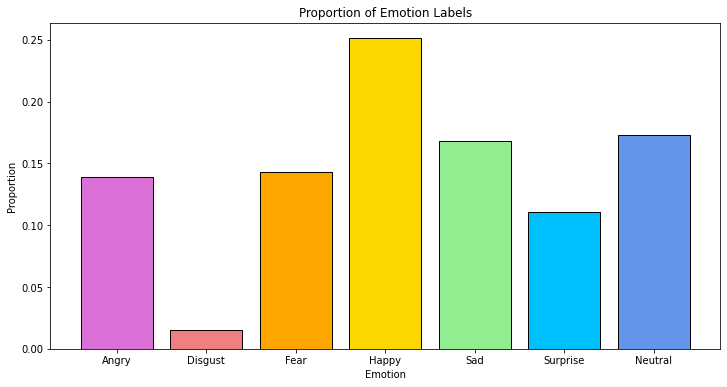

In [24]:
plot_emotions_distribution(train_dataset)

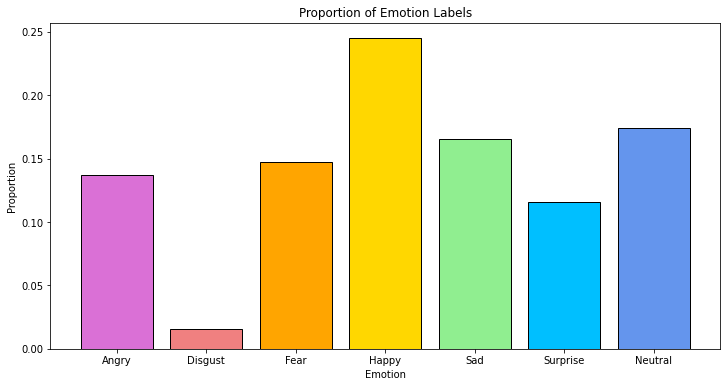

In [25]:
plot_emotions_distribution(validation_dataset)

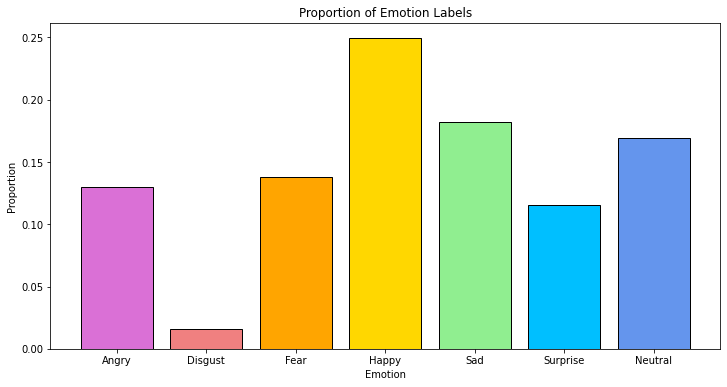

In [26]:
plot_emotions_distribution(test_dataset)

## Показываю изображения

In [27]:
plt.close()
def plot_images(dataset, labels):
  plt.rcParams["figure.figsize"] = [16,16]
  emotions = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
  row = 0
  for emotion in np.unique(labels):

      all_emotion_images = dataset[dataset['emotion'] == emotion]
      for i in range(5):
          
          img = all_emotion_images.iloc[i,].pixels.reshape(48,48)
          lab = emotions[emotion]

          plt.subplot(7,5,row+i+1)
          plt.imshow(img, cmap='binary_r')
          plt.text(-30, 5, s = str(lab), fontsize=10, color='b')
          plt.axis('off')
      row += 5

  plt.show()

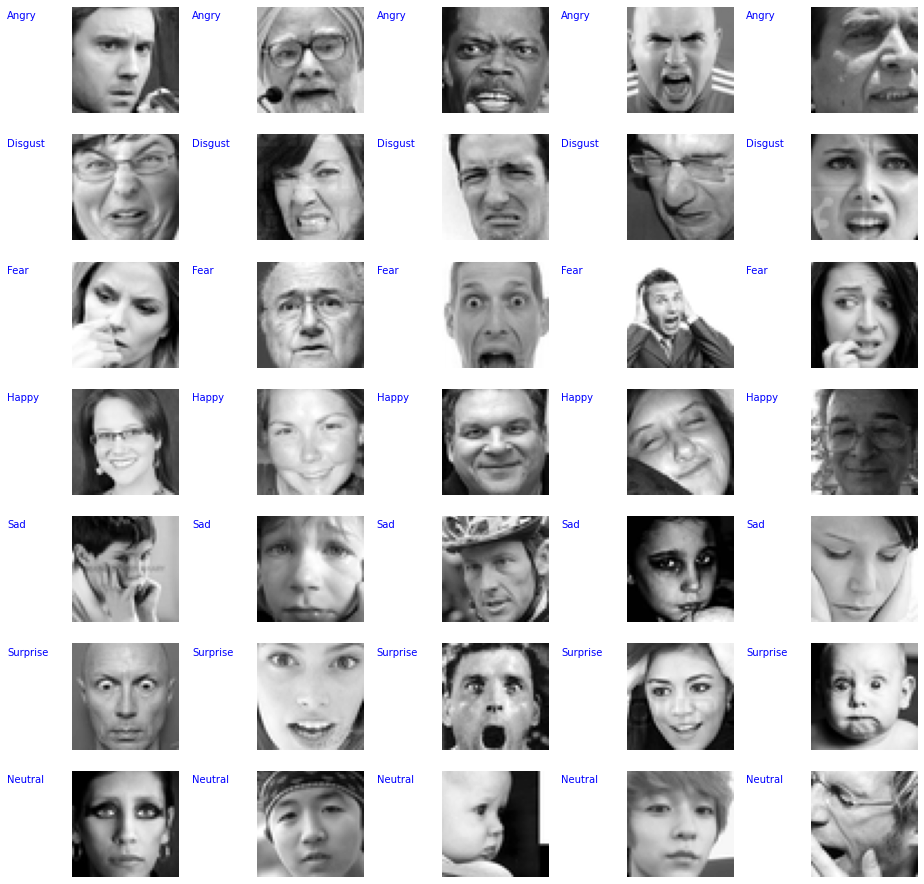

In [28]:
plot_images(train_dataset, y_train)

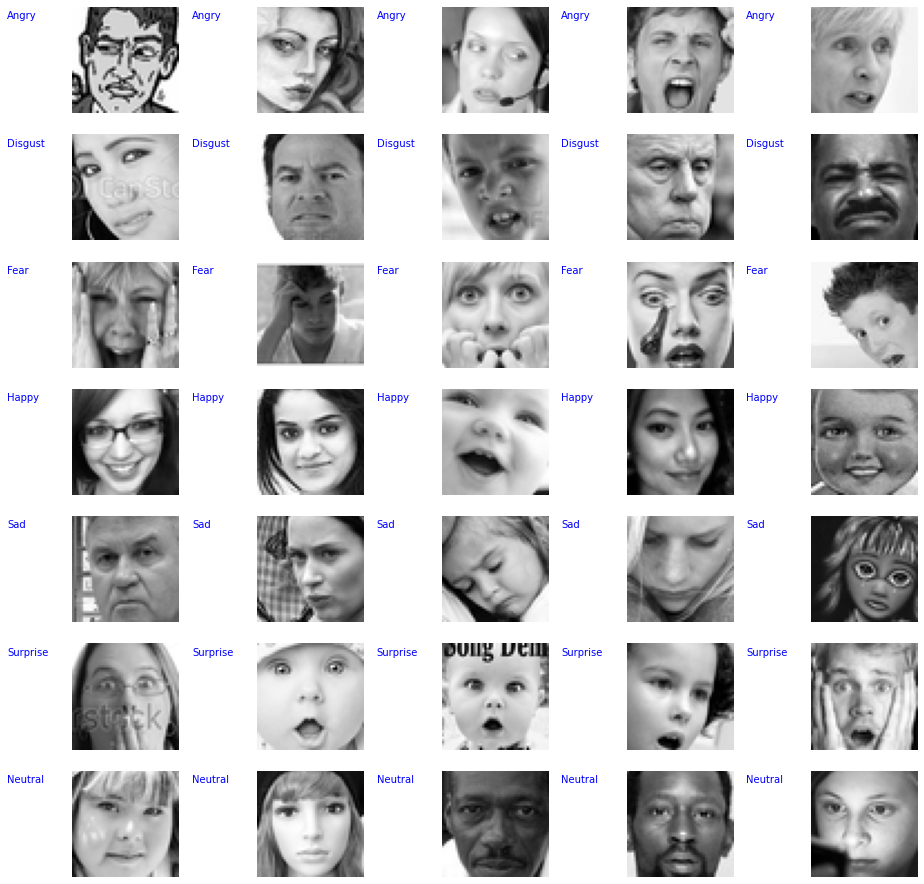

In [29]:
plot_images(test_dataset, y_test)

## Получение фото из директорий
С помощью ImageDataGenerator мы получаем итераторы с изображениями

In [30]:
def loader(dir_train, dir_val, batch):
  train_datagen = ImageDataGenerator(
    rescale = 1./255
  )

  train_loader = train_datagen.flow_from_directory(
      directory= dir_train,
      target_size=(48, 48),
      color_mode="rgb",
      batch_size=batch,
      class_mode="categorical",
      shuffle=True,
      seed=123456
  )

  val_loader = train_datagen.flow_from_directory(
      directory=dir_val,
      target_size=(48, 48),
      color_mode="rgb",
      batch_size=batch,
      class_mode="categorical",
      shuffle=True,
      seed=123456
  )

  return train_loader, val_loader

### Проверка итераторов

In [31]:
train_loader, val_loader = loader("./dataset/train/","./dataset/test/", 64 )

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [32]:
def plot_iterator(train_loader):
  x,y= train_loader.next()
  print(x.shape)
  plt.rcParams["figure.figsize"] = [16,16]
  for i in range(0,20):
    plt.subplot(7,5,i+1)
    image = x[i]
    plt.imshow(image)
    plt.axis('off')
  plt.show()

(64, 48, 48, 3)


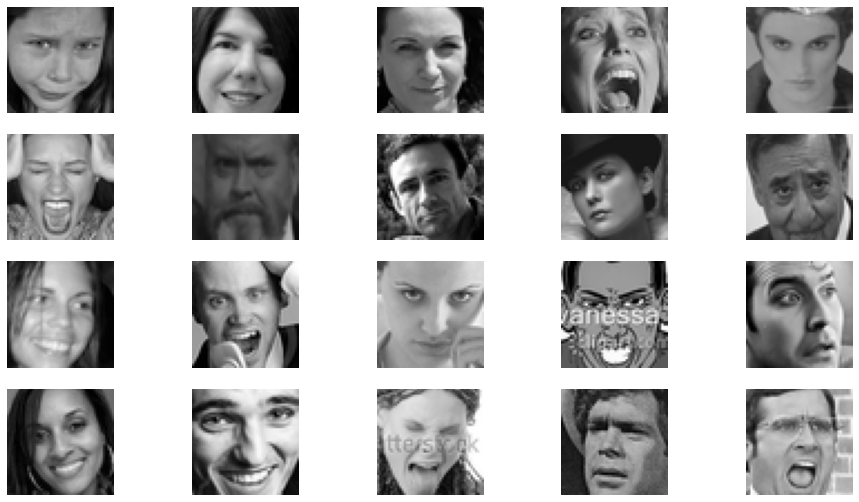

In [33]:
plot_iterator(train_loader)

# Построение модели



DenseNet

" Она является сверточной нейронной сетью. Можно загрузить предварительно обученную версию сети, обученной больше чем на миллионе изображений от базы данных ImageNet.

Предварительно обученная сеть может классифицировать изображения в 1 000 категорий объектов, таких как клавиатура, мышь, карандаш и многие животные.

В результате сеть изучила богатые представления функции для широкого спектра изображений. "

" В DenseNet каждый слой получает дополнительные входные данные от всех предыдущих слоев и передает свои собственные карты характеристик всем последующим слоям. "

“ Для каждого слоя карты объектов всех предыдущих слоев используются в качестве входных данных, а его собственные карты объектов используются в качестве входных данных для всех последующих слоев. “

“ DenseNets имеет несколько неоспоримых преимуществ:

- они облегчают проблему исчезающего - градиента,
- улучшают распространение функций,
- поощряют повторное использование функций
- существенно сокращают количество - параметров. “

## Функция сохдания модели

In [34]:
def Dense_model():
  input_shape_densenet = (48, 48, 3)
  densenet_model = keras.applications.DenseNet201(
      include_top=False,
      weights="imagenet",
      input_tensor=None,
      input_shape=input_shape_densenet
  )
  
  densenet_model.trainable = True # True


  input = keras.Input(shape=(48, 48, 3))
  layer = densenet_model(inputs=input)
  layer = keras.layers.Flatten()(layer)
  layer = keras.layers.Dense(units=512, activation='relu')(layer)
  layer = keras.layers.Dropout(0.4)(layer)
  layer = keras.layers.Dense(units=256, activation='relu')(layer)
  layer = keras.layers.Dropout(0.4)(layer)
  layer = keras.layers.Dense(units=128, activation='relu')(layer)
  layer = keras.layers.Dropout(0.3)(layer)
  output = keras.layers.Dense(units=7, activation='softmax')(layer)

  model = keras.models.Model(inputs=input, outputs=output)
  return model

## Проверка созданной модели

In [35]:
model = Dense_model()
model.summary()

74850304/74836368 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 densenet201 (Functional)    (None, 1, 1, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 512)               983552    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                              

# Тренировка модели

### функция тренировки модели

In [36]:
def modelfit(model,trainloader, valloader, epochs,lr, steps, class_w = False):
  NUM_EPOCHS = epochs 


  #Otimizators
  adam = Adam(learning_rate=lr) 
  rms = optimizers.rmsprop_v2.RMSProp(lr)
  sgd = optimizers.gradient_descent_v2.SGD(lr)
  adelta = optimizers.adadelta_v2.Adadelta(lr)
  adagrad = optimizers.adagrad_v2.Adagrad(lr)

  model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])
  es = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                     mode='max',
                                     verbose=1,
                                     patience=7,
                                     min_delta=1e-3,
                                     restore_best_weights=True)
  
  reducelr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=2,
                              min_lr=0.000001,
                              mode='min')

  
  if class_w:
    class_weights = class_weight.compute_class_weight(class_weight='balanced', classes= np.unique(trainloader.classes), y= trainloader.classes)
    weight = {i : class_weights[i] for i in range(7)}
    print("Class Weight: ", weight)
  
    history=model.fit(train_loader, 
                      epochs= NUM_EPOCHS,
                      validation_data = valloader,
                      shuffle= True,
                      steps_per_epoch= steps,
                      callbacks=[es,reducelr],
                      class_weight=weight
    )
  else:
    history=model.fit(train_loader, 
                      epochs= NUM_EPOCHS,
                      validation_data = valloader,
                      shuffle= True,
                      steps_per_epoch= steps,
                      callbacks=[es,reducelr]
    )
  return history

## сохранение/загрузка модели

In [37]:
def save_model(model, model_name, weight_name):
  model_json = model.to_json()
  with open(model_name, "w") as json_file:
    json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights(weight_name)
  print("Saved model to disk")


def load_model(model_name, weight_name):
  # load json and create model
  json_file = open(model_name, 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  model = model_from_json(loaded_model_json)
  # load weights into new model
  model.load_weights(weight_name)
  print("Loaded model from disk")
  return model

## график истории обучения

In [38]:
def plot_graphic_history(history):
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy in history')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss in history')
    plt.show()


def graphic_acc_loss_per_epochs(lists_history):
  for history in lists_history:
    plot_graphic_history(history)

## тестирование метрик

In [39]:
def test_metrics(model, x,y_true):
  y_pred = modelpred(model,x)
  draw_confusion_matrix(y_true, y_pred)

## аугментация тренировачного набора данных

In [40]:
def augmentate_train_set(train_dir):
  labels = [0,1,2,3,4,5,6]
  paths_train = []
  for label in labels:
    paths_train.append(os.path.join(train_dir,str(label)))
  data_augmentate_from_directory(paths_train ,n_generate=4)

## функции для снятия метрик

In [41]:
import seaborn as sns


def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds, normalize='true')
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap="viridis")
    plt.show()
    print(sklearn.metrics.classification_report(true, preds, digits=5))


def modelpred(model,test_full):
  y_get = model.predict(test_full)
  result = []

  for p in y_get:
    result.append(np.argmax(p))

  return result

# Начало аугментации и тренировки

In [49]:
def augmentate_by_class(root_dir, root_labels, X_root, labels_spec, x_spec ):
  labels = root_labels 
  paths_train = []

  for label in labels:
    paths_train.append(os.path.join(root_dir,str(label)))
  data_augmentate_from_directory(paths_train ,n_generate=X_root)
  
  paths_train = []
  for label in labels_spec:
    paths_train.append(os.path.join(root_dir,str(label)))

  data_augmentate_from_directory(paths_train ,n_generate=x_spec)

класс [1] аугментирую больше, чтобы добиться баланса, т.к. таких изображений меньше всего

In [ ]:
augmentate_by_class("./dataset/train", [0,2,3,4,5,6], 5, [1], 10)
train_loader, val_loader = loader("./dataset/train", "./dataset/validation", 64)

100%|██████████| 1/1 [00:05<00:00,  5.37s/it]


Found 158277 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [ ]:
# !rm -rf ./dataset/

In [ ]:
model = Dense_model()
list_model = [] 
list_model.append(modelfit(
    model=model,
    trainloader=train_loader,
    valloader=val_loader,
    epochs=50,
    lr=0.0001,
    steps=157000//64,
    class_w=False
))

Epoch 1/50
2453/2453 [==============================] - 664s 261ms/step - loss: 1.6760 - accuracy: 0.3327 - val_loss: 1.2044 - val_accuracy: 0.5428 - lr: 1.0000e-04
Epoch 2/50
2453/2453 [==============================] - 636s 259ms/step - loss: 1.3704 - accuracy: 0.4861 - val_loss: 1.0859 - val_accuracy: 0.5823 - lr: 1.0000e-04
Epoch 3/50
2453/2453 [==============================] - 632s 258ms/step - loss: 1.2264 - accuracy: 0.5457 - val_loss: 1.0044 - val_accuracy: 0.6202 - lr: 1.0000e-04
Epoch 4/50
2453/2453 [==============================] - 633s 258ms/step - loss: 1.1059 - accuracy: 0.5946 - val_loss: 0.9769 - val_accuracy: 0.6364 - lr: 1.0000e-04
Epoch 5/50
2453/2453 [==============================] - 635s 259ms/step - loss: 0.9833 - accuracy: 0.6431 - val_loss: 0.9594 - val_accuracy: 0.6534 - lr: 1.0000e-04
Epoch 6/50
2453/2453 [==============================] - 635s 259ms/step - loss: 0.8507 - accuracy: 0.6948 - val_loss: 0.9736 - val_accuracy: 0.6656 - lr: 1.0000e-04
Epoch 7/50

# Сохранение модели

In [ ]:
save_model(model, "./modelAugClass1SW.json", "./modelAugClass1SW.h5")

Saved model to disk


# Тестирование модели

In [ ]:
score = model.evaluate(val_loader, verbose=1)

57/57 [==============================] - 5s 86ms/step - loss: 1.2468 - accuracy: 0.6715


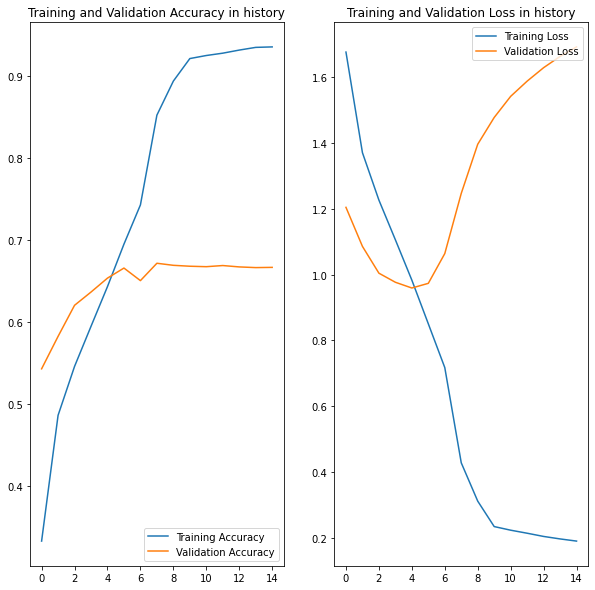

In [ ]:
graphic_acc_loss_per_epochs(list_model)

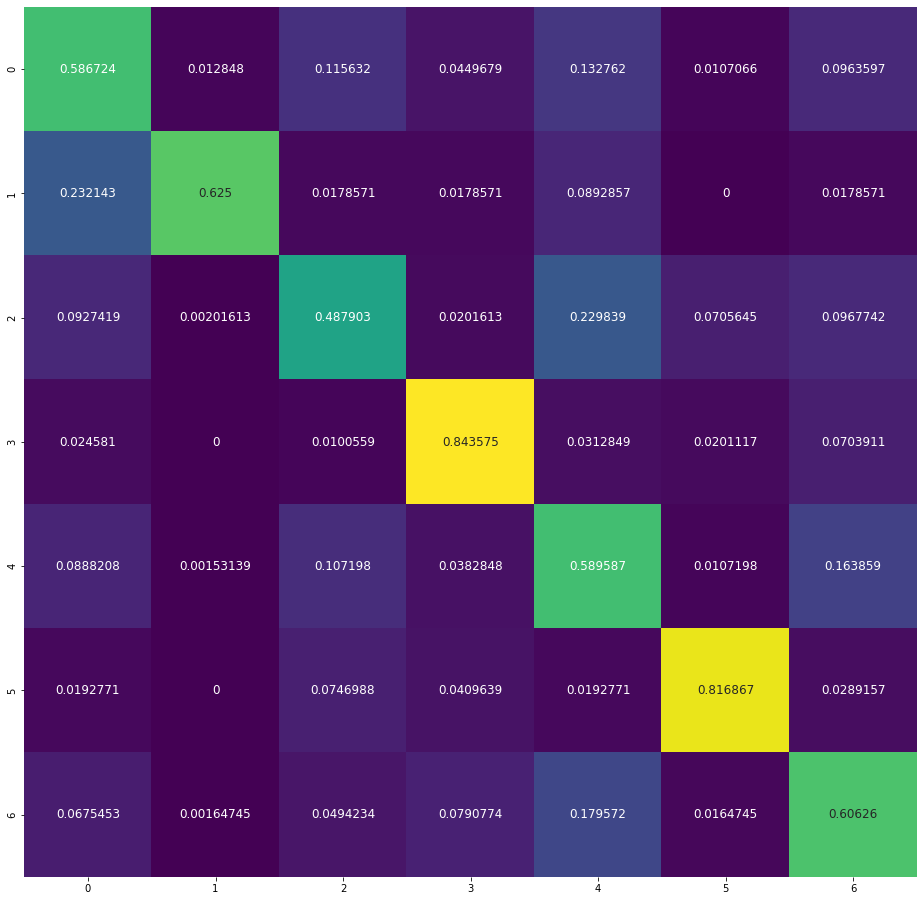

              precision    recall  f1-score   support

           0    0.59307   0.58672   0.58988       467
           1    0.79545   0.62500   0.70000        56
           2    0.55378   0.48790   0.51876       496
           3    0.86089   0.84358   0.85214       895
           4    0.54149   0.58959   0.56452       653
           5    0.81884   0.81687   0.81785       415
           6    0.57143   0.60626   0.58833       607

    accuracy                        0.66815      3589
   macro avg    0.67642   0.65085   0.66164      3589
weighted avg    0.67065   0.66815   0.66865      3589



In [ ]:
test_metrics(model, X_test/255, y_test)

# Дообучение модели

## загружаю сохранённую модель

In [42]:
model = load_model("./modelAugClass1SW.json", "./modelAugClass1SW.h5")

Loaded model from disk


In [43]:
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 densenet201 (Functional)    (None, 1, 1, 1920)        18321984  
                                                                 
 flatten_11 (Flatten)        (None, 1920)              0         
                                                                 
 dense_44 (Dense)            (None, 512)               983552    
                                                                 
 dropout_33 (Dropout)        (None, 512)               0         
                                                                 
 dense_45 (Dense)            (None, 256)               131328    
                                                                 
 dropout_34 (Dropout)        (None, 256)               0  

In [44]:
print('Number of layers in base model:', len(model.layers[1].layers), '\n')

print('Names of last ten layers:')
for layer in model.layers[1].layers[-226:]:
    print(layer.name)

Number of layers in base model: 707 

Names of last ten layers:
conv5_block1_0_bn
conv5_block1_0_relu
conv5_block1_1_conv
conv5_block1_1_bn
conv5_block1_1_relu
conv5_block1_2_conv
conv5_block1_concat
conv5_block2_0_bn
conv5_block2_0_relu
conv5_block2_1_conv
conv5_block2_1_bn
conv5_block2_1_relu
conv5_block2_2_conv
conv5_block2_concat
conv5_block3_0_bn
conv5_block3_0_relu
conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_conv
conv5_block3_concat
conv5_block4_0_bn
conv5_block4_0_relu
conv5_block4_1_conv
conv5_block4_1_bn
conv5_block4_1_relu
conv5_block4_2_conv
conv5_block4_concat
conv5_block5_0_bn
conv5_block5_0_relu
conv5_block5_1_conv
conv5_block5_1_bn
conv5_block5_1_relu
conv5_block5_2_conv
conv5_block5_concat
conv5_block6_0_bn
conv5_block6_0_relu
conv5_block6_1_conv
conv5_block6_1_bn
conv5_block6_1_relu
conv5_block6_2_conv
conv5_block6_concat
conv5_block7_0_bn
conv5_block7_0_relu
conv5_block7_1_conv
conv5_block7_1_bn
conv5_block7_1_relu
conv5_block7_2_conv
conv

## Замораживаю модель
размораживаю только последних 226 слоев

In [45]:
model.trainable = True
for layer in model.layers[1].layers[:-226]:
    layer.trainable = False

model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 densenet201 (Functional)    (None, 1, 1, 1920)        18321984  
                                                                 
 flatten_11 (Flatten)        (None, 1920)              0         
                                                                 
 dense_44 (Dense)            (None, 512)               983552    
                                                                 
 dropout_33 (Dropout)        (None, 512)               0         
                                                                 
 dense_45 (Dense)            (None, 256)               131328    
                                                                 
 dropout_34 (Dropout)        (None, 256)               0  

## Обновляю данные

In [46]:
!rm -rf ./dataset/

In [47]:
dataset_dir = "./dataset"
train_dir = "./dataset/train"
val_dir = "./dataset/validation"
test_dir = "./dataset/test"

os.makedirs(dataset_dir,exist_ok=True)
os.makedirs(train_dir,exist_ok=True)
os.makedirs(val_dir,exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

labels = [0,1,2,3,4,5,6]

for label in labels:
  os.makedirs(os.path.join(train_dir,str(label)),exist_ok=True)
  os.makedirs(os.path.join(val_dir,str(label)),exist_ok=True)
  os.makedirs(os.path.join(test_dir,str(label)),exist_ok=True)

numbers_name = np.arange(1,1000000)

images_in_dir(train_dir, X_train, y_train)
images_in_dir(val_dir, X_val, y_val)
images_in_dir(test_dir, X_test, y_test)

In [52]:
augmentate_by_class("./dataset/train", [0,3,4,5,6], 2, [1,2], 4)

100%|██████████| 2/2 [00:24<00:00, 12.33s/it]


In [53]:
train_loader, val_loader = loader("./dataset/train", "./dataset/validation", 64)

Found 91413 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


## Дотренировываю модель

In [54]:
list_model = [] 
list_model.append(modelfit(
    model=model,
    trainloader=train_loader,
    valloader=val_loader,
    epochs=50,
    lr=0.00001,
    steps=91000//64,
    class_w=False
))

Epoch 1/50
1421/1421 [==============================] - 201s 121ms/step - loss: 0.9035 - accuracy: 0.6915 - val_loss: 0.9487 - val_accuracy: 0.6712 - lr: 1.0000e-05
Epoch 2/50
1421/1421 [==============================] - 163s 115ms/step - loss: 0.8689 - accuracy: 0.6945 - val_loss: 0.9568 - val_accuracy: 0.6690 - lr: 1.0000e-05
Epoch 3/50
1421/1421 [==============================] - 164s 116ms/step - loss: 0.8594 - accuracy: 0.6976 - val_loss: 0.9624 - val_accuracy: 0.6715 - lr: 1.0000e-05
Epoch 4/50
1421/1421 [==============================] - 163s 115ms/step - loss: 0.8550 - accuracy: 0.6975 - val_loss: 0.9646 - val_accuracy: 0.6701 - lr: 1.0000e-06
Epoch 5/50
1421/1421 [==============================] - 164s 116ms/step - loss: 0.8510 - accuracy: 0.6984 - val_loss: 0.9628 - val_accuracy: 0.6715 - lr: 1.0000e-06
Epoch 6/50
1421/1421 [==============================] - 166s 117ms/step - loss: 0.8509 - accuracy: 0.6974 - val_loss: 0.9638 - val_accuracy: 0.6701 - lr: 1.0000e-06
Epoch 7/50

## Сохраняю модель

In [ ]:
save_model(model, "modelAugClass1SWFinned.json", "modelAugClass1SWFinned.h5")

# Результаты

In [55]:
score = model.evaluate(val_loader, verbose=1)

57/57 [==============================] - 5s 83ms/step - loss: 0.9487 - accuracy: 0.6712


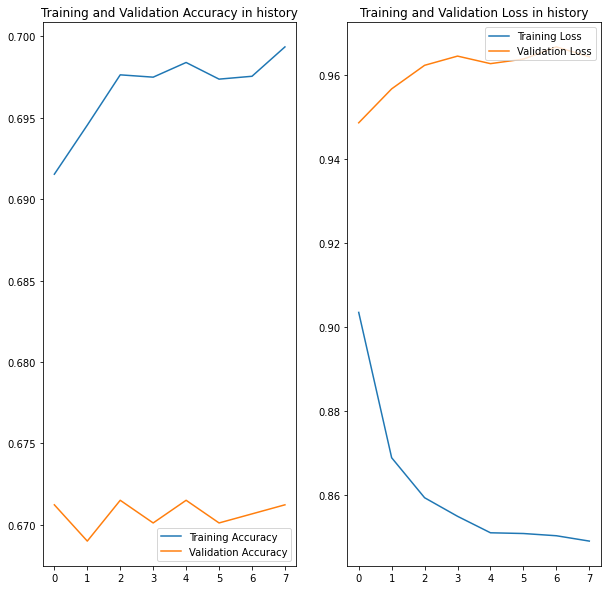

In [56]:
graphic_acc_loss_per_epochs(list_model)

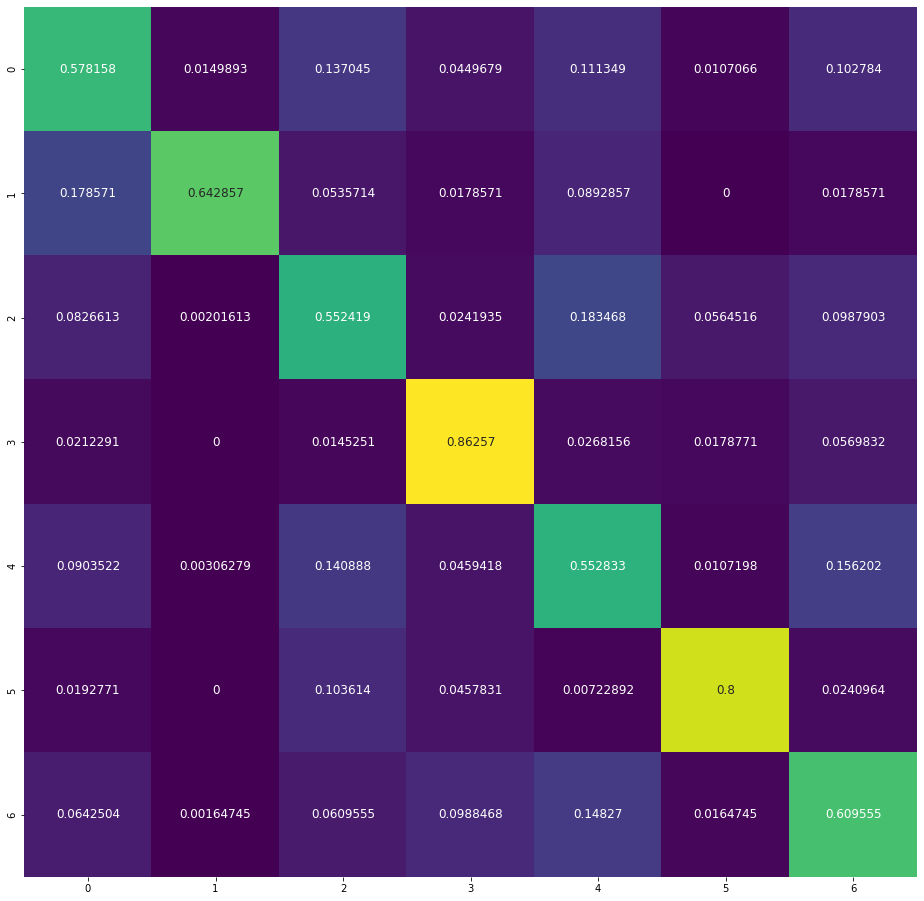

              precision    recall  f1-score   support

           0    0.60538   0.57816   0.59146       467
           1    0.76596   0.64286   0.69903        56
           2    0.52091   0.55242   0.53620       496
           3    0.84372   0.86257   0.85304       895
           4    0.57668   0.55283   0.56450       653
           5    0.83417   0.80000   0.81673       415
           6    0.58637   0.60956   0.59774       607

    accuracy                        0.67289      3589
   macro avg    0.67617   0.65691   0.66553      3589
weighted avg    0.67366   0.67289   0.67294      3589



In [57]:
test_metrics(model, X_test/255, y_test)